## Homework 11: The Adventure of the 2001 Dimensions
##### By: Kevin Liu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(112)

### 1. Reproduce Watsons’s K-Means Result

First, we will modify the K-means clustering procedure from one of our previous works such that it can accommodate the 2001 dimensions in the current dataset, run it for 20-100 iterations while starting from several different initializations, and report the lowest total squared distance (i.e., the best clustering results) we find for $K=8$. The clustering sum of squared distances will then be compared to the value obtained by Watson.

In [2]:
def sample_component(X):
    """
    Modified based on pset_05 Dr. Sean Eddy's solutions
    Returns a random centroid position
    Input: X[i,g] = the actual data; we use this to determine the min/max in each dimension,
                    and we sample a random vector uniformly on each dimension within those bounds.
    """
    N, G   = np.shape(X)
    dmax   = np.amax(X, axis=0)
    dmin   = np.amin(X, axis=0)
    mu     = np.zeros(G)
    for g in range(G):
        mu[g] = np.random.uniform(dmin[g], dmax[g])
        
    return mu


def closest_centroid(x, centroids):
    """
    Modified based on pset_05 Dr. Sean Eddy's solutions
    Input:
       centroids[k,g] : the current centroid positions, for centroids k=0..K-1, dimensions/genes g=0..G-1
       x[g]:            one data point
    Returns best_k, best_dist:
       best_k         : index of the best centroid (0..K-1)
       best_d         : distance to the best centroid
    """
    K, dim = np.shape(centroids)
    best_k = 0
    best_dist = np.linalg.norm(x-centroids[0])
    for k in range(1,K):
        dist = np.linalg.norm(x-centroids[k])
        if dist < best_dist:
            best_k    = k
            best_dist = dist
            
    return best_k, best_dist


def assign_kmeans(X, centroids):
    """
    Adapted from pset_05 Dr. Sean Eddy's solutions
    Input:
       X[i,g] are the data point
       centroids[k] are the current centroid positions
    Return assignments, totdist:
       assignments[i] assign each data point i to a cluster k
       tot_sqdist is the total squared distance, the k-means objective function
    """
    K, dim      = np.shape(centroids)
    N           = len(X)
    assignments = np.zeros(N).astype(int)
    tot_sqdist  = 0
    for i,x in enumerate(X):
        assignments[i], di = closest_centroid(x, centroids)
        tot_sqdist += di**2
        
    return assignments, tot_sqdist


def update_kmeans(X, assignments, K):
    """
    Adapted from pset_05 Dr. Sean Eddy's solutions
    Input:
      X[i,g] are the data points; i=0..N-1,  g=0..G-1
      assignments[i] : which centroid (0..K-1) each point has just been assigned to
      K : how many centroids there are
    Returns:
      centroids[k,g] : updated centroid positions
      pk[k]          : frequency of using component k: how many points were assigned to it, normalized.
    """
    N, G    = np.shape(X)              
    
    centroids = np.zeros((K,G))        
    counts    = np.zeros(K)
    for i in range(N):
        counts[assignments[i]] += 1
        for g in range(G):
            centroids[assignments[i], g] += X[i][g]

    for k in range(K):
        if counts[k] > 0:
            centroids[k] = np.divide(centroids[k], counts[k])
        else:
            centroids[k] = sample_component(X)

    Z = np.sum(counts)
    counts = np.divide(counts, Z)
    
    return centroids, counts


def diff_assignments(a1, a2):
    """
    Adapted from pset_05 Dr. Sean Eddy's solutions
    Returns the number of assignments that differ between <a1> and <a2>,
    where these are, e.g., a1[i] = 0..K-1, a cluster assignment for each cell i.
    """
    N     = len(a1)
    ndiff = 0
    for i in range(N):
        if a1[i] != a2[i]: 
            ndiff += 1
            
    return ndiff


def kmeans(X, K = 8, T = np.zeros(0)):
    """
    Modified based on pset_05 Dr. Sean Eddy's solutions
    Input:
       X[i,g]:  data points i=0..N-1, each of which is a vector w/ g=0..G-1
       K     :  how many clusters to fit, defaulted to K = 8 for this pset
       T[i]  :  OPTIONAL: known/true cluster assignments; initialize centroids on their true positions
    Return (kp, centroids, assignments, totdist):
       kp[k] :  probability mass (# of data points) assigned to component k
       centroids[k,g] : locations of each cluster centroid
       assignments[i] : which centroid 0..K-1 that each data point i=0..N-1 is assigned to
       tot_sqdist:      total squared Euclidean distance for this k-means solution.
    """
    N, G = np.shape(X)
    
    if len(T) > 0:
        centroids, qp = update_kmeans(X, T, K)
    else:
        centroids = np.zeros((K,G))
        for k in range(K):
            centroids[k] = sample_component(X)
    
    iteration = 0
    while True:
        assignments, tot_sqdist = assign_kmeans(X, centroids)
        if iteration >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff == 0:
                break
        centroids, kp   = update_kmeans(X, assignments, K)
        old_assignments = assignments
        iteration      += 1
        
    kp = np.zeros(K)
    for i in range(N):
        kp[assignments[i]] += 1
    kp = np.divide(kp, N)

    return kp, centroids, assignments, tot_sqdist


def lowest_sqdist(data, n_runs):
    """
    Calculates and returns the lowest total squared distance after running kmeans() for n_runs iterations
    """
    tot_sqdist_list, assignments_list, centroids_list = [], [], []
    
    for i in range(n_runs):
        kp, centroids, assignments, tot_sqdist = kmeans(data)
        tot_sqdist_list.append(tot_sqdist)
        assignments_list.append(assignments)
        centroids_list.append(centroids)
        
    assignments = assignments_list[np.argmin(tot_sqdist_list)]
    centroids = centroids_list[np.argmin(tot_sqdist_list)]
    min_tot_sqdist = min(tot_sqdist_list)
    
    return assignments, centroids, min_tot_sqdist

In [3]:
# Read in the data
data, genes = [], []
with open('w11-data.tbl') as f:
    for n, line in enumerate(f):
        if n == 0:
            genes = line.split()
        else:
            fields = line.split()
            data.append([int(i) for i in fields])

# Convert data to numpy array
data = np.asarray(data)

# Log-transform the data
data_log = np.log(data)

In [4]:
# Run kmeans() for 20-100 iterations and get the lowest total squared distance
n_runs = np.random.randint(20, 100)
assignments, centroids, min_tot_sqdist = lowest_sqdist(data = data_log, n_runs = n_runs)
print('For {} iterations, the lowest total squared distance is {:.1f}.'.format(n_runs, min_tot_sqdist))

For 63 iterations, the lowest total squared distance is 87879.6.


As shown above, the lowest total squared distance we determined closely matches the value of 87378.2 obtained by Watson.

### 2. Reduce the Dimensionality

Subsequently, we will define a function that uses singular value decomposition to calculate the principal components of a data set and apply it to our log-transformed data.

In [5]:
def PCA(data):
    """
    Uses singular value decomposition to find the PCs of the dataset
    """
    centered_data = data - np.mean(data, axis = 0)
    u, s, wt = np.linalg.svd(centered_data)
    w = wt.T
    PCs = centered_data @ w
    
    return u, s, wt, w, PCs

In [6]:
# Use singular value decomposition to find the PCs of the log-transformed data
u, s, wt, w, PCs = PCA(data_log)

We will then plot all 200 cells in 2D expression space using their projections onto the first two principal axes.

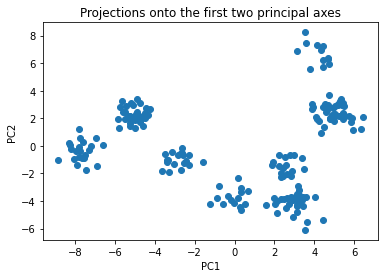

In [7]:
# Plot all 200 cells in 2D expression space using their projections onto the first two principal axes
plt.scatter(PCs[:, 0], PCs[:, 1])
plt.title('Projections onto the first two principal axes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Following singular value decomposition of the log-transformed data and plotting all 200 cells in 2D expression space using their projections onto the first two principal axes, we observe that there are 8 distinct clusters present, which is consistent with Watsons's claim that there are 8 clusters.

Next, we will compute the eigenvalues for each component and plot them to further examine this finding by using negative control data as a reference.

In [8]:
# Calculate the eigenvalues
lambdas = (s**2) / (data.shape[0] - 1)

# Calculate the % of variance captured by each PC
frac = lambdas / np.sum(lambdas)

# Read in the eigenvalues for the negative control
lambdas_neg = []
with open('w11-eigen.tbl') as f:
    for n, line in enumerate(f):
        fields = line.split()
        lambdas_neg.append(float(fields[1]))

# Calculate the % of variance captured by each PC for the negative control
frac_neg = lambdas_neg / np.sum(lambdas_neg)

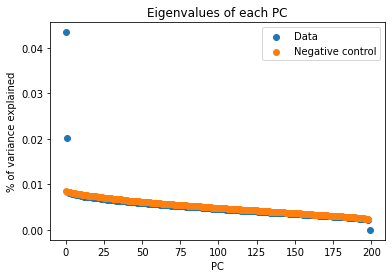

In [9]:
# Plot the % of variance explained for each PC
plt.scatter(range(len(frac)), frac, label = 'Data')
plt.scatter(range(len(frac_neg)), frac_neg, label = 'Negative control')
plt.title('Eigenvalues of each PC')
plt.xlabel('PC')
plt.ylabel('% of variance explained')
plt.legend()
plt.show()

In [10]:
# Find the eigenvalues that are higher than negative control
for i in range(len(frac)):
    if frac[i] < frac_neg[i]:
        break
q = i # number of signal PCs
print('Number of signal PCs (q): ', q)

Number of signal PCs (q):  2


Since we simulated our negative control data such that there are no cell types and no correlations between any of the genes, the resulting eigenvalues would thus represent noise.

By examining the eigenvalues for each component along with our negative control data, it is apparent that the first two principal components explain the greatest amount of variance within our data and may as a result be sufficient for clustering. Furthermore, we observe that most of the remaining princical components' corresponding eigenvalues are no different than our negative control, which suggests that they may represent noise in our dataset. Based on such evidence, we are more confident in the claim that there are only $K = 8$ clusters in our data.

Here, we will attempt to identify the genes that appear to influence cell type identity based on the eigenvector loadings of the first to principal axes.

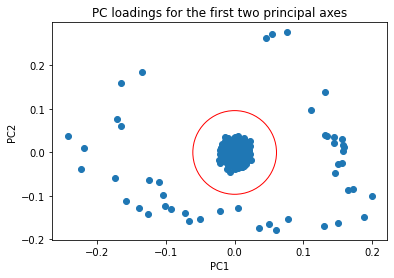

In [11]:
# PC loadings for the first 2 eigenvectors
plt.scatter(w[:, 0], w[:, 1])
plt.scatter(0, 0, s = 7000, facecolors = 'none', edgecolors = 'r') 
plt.title('PC loadings for the first two principal axes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

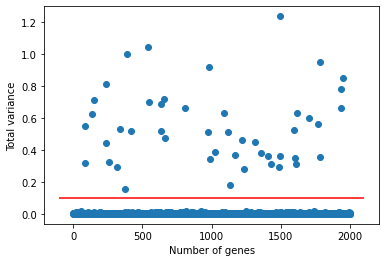

In [12]:
tot_var_PCs = np.sum((w[:, :2]**2) @ np.diag(lambdas[0:2]), axis = 1)

plt.plot(tot_var_PCs, 'o')
x_min, x_max = plt.xlim()
plt.hlines(y = 0.1, xmin = x_min, xmax = x_max, color = 'red')
plt.xlabel('Number of genes')
plt.ylabel('Total variance')
plt.show()

Based on the above plots, it is apparent that the majority of genes do not contribute much to the variance along the first two principal components while a small number of genes seem to have a large contribution to the variances. We will thus define a threshold of 0.1 (plotted as a red circle and red horizontal line, respectively) for each principal component to identify these genes that may be most influential to the cell type identity; the number and identity of such genes are listed below.

In [13]:
# Filter influential genes based on PC1 and PC2 using a threshold of 0.1 as determined above
influential_gene_idx = np.array(np.where((np.abs(w[:, 0]) > 0.1) | (np.abs(w[:, 1]) > 0.1))).flatten()

influential_genes = []
for i in range(len(influential_gene_idx)):
    influential_genes.append(genes[i])

print('There are {} influential genes:\n{}'.format(len(influential_gene_idx), ', '.join(influential_genes)))

There are 47 influential genes:
arugula, blueberry, cabbage, chickpea, clementine, cranberry, honeydew, mulberry, mustard, onion, pear, plum, sage, strawberry, PERM1, ATAD3C, ATAD3B, PLCH2, SMIM1, RNF207, PLEKHG5, ZBTB48, TMEM201, FBXO44, MAD2L2, PRAMEF11, PRAMEF9, DDI2, TMEM82, FBXO42, PADI6, AKR7A3, HTR6, TMCO4, PLA2G2E, PLA2G2D, VWA5B1, CDA, PINK1, CELA3B, EPHB2, RPL11, HMGCL, RSRP1, TMEM50A, RP11-96L14.7, AIM1L


### 3. Check the K

Following K-means clustering of our data, we will attempt to plot the data in 2D principal component space and color each point according to their cluster assignments from the previously determined assignments.

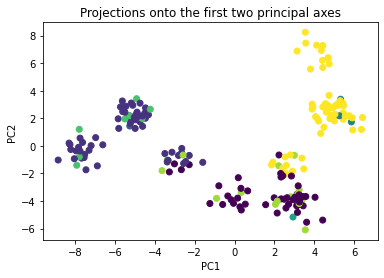

In [14]:
# Visualize the kmeans clustering results
plt.scatter(PCs[:, 0], PCs[:, 1], c = assignments)
plt.title('Projections onto the first two principal axes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Based on the above plot of the clustering assignments, we see that K-means did not give a satisfactory performance as most of the cluster assignments are incorrectly assigned.

Here, we may attribute the incorrect assignments from K-means to the noise within our data. To test this claim, we will examine the percent of variance explained by the remaining principal components as shown below.

In [15]:
# Calculate the variance in our data
noise = 1 - np.sum(frac[0:2]) / np.sum(frac)
print('{:.1%} of variance based on the remaining PCs is attributed to noise from the data.'.format(noise))

93.6% of variance based on the remaining PCs is attributed to noise from the data.


Next, we will plot the cumulative variance explained by $q$ number of principal components to assess the amount of variance explained as we increase the number of principal components.

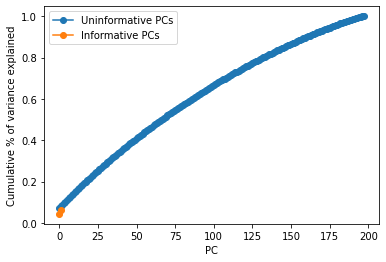

In [16]:
# Cumulative variance explained by q PCs
cum_var = np.cumsum(frac)

plt.plot(range(len(cum_var[q:])), cum_var[q:], marker = 'o', label = 'Uninformative PCs')
plt.plot(range(len(cum_var[:q])), cum_var[:q], marker = 'o', label = 'Informative PCs')
plt.xlabel('PC')
plt.ylabel('Cumulative % of variance explained')
plt.legend()
plt.show()

As expected, we see that as the number of PCs increase, we observe increasing amounts of percent variance explained. However, we also observe that the the first two principal components explain a relatively small amount of variance while those for other principal components are significantly larger, suggesting that such noise will introduce difficulties for our K-means algorithm to correctly resolve the cluster assignments.

To circumvent this issue of noise, we will simply use the projections of the first two principal components based on our data to perform K-means clustering and obtain the new cluster assignments, as shown below.

In [17]:
# Use the PC1 and PC2 projections to run kmeans
assignments_PCA, centroids_PCA, min_tot_sqdist_PCA = lowest_sqdist(data = PCs[:, :2], n_runs = n_runs)
print('For {} iterations, the lowest total squared distance is {:.1f}.'.format(n_runs, min_tot_sqdist_PCA))

For 63 iterations, the lowest total squared distance is 130.6.


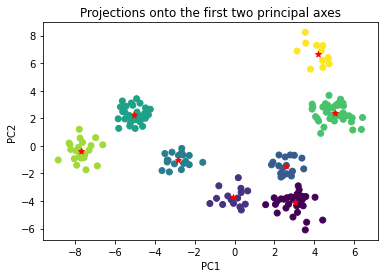

In [18]:
# Visualize the kmeans clustering results
plt.scatter(PCs[:, 0], PCs[:, 1], c = assignments_PCA)
plt.scatter(centroids_PCA[:, 0], centroids_PCA[:, 1], marker = '*', color = 'red')
plt.title('Projections onto the first two principal axes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

As expected, using PC1 and PC2 projections have yielded satisfactory cluster assignments with our K-means clustering algorithm, such that each of the 200 cells are appropriately assigned within the 2D principal component space.

### 4. Reconstruct the Expression Patterns

Lastly, we will attempt to reconstruct the original data using only the projected data and eigenvectors for the first two principal components to obtain a "denoised" dataset and visualize the data using a heatmap to see if there are any distinguishable clusters.

In [19]:
# Reconstruct the data using the first 2 PCs
data_PCA = u[:, :2] @ np.diag(s[:2]) @ wt[:2, :]
data_PCA.shape

(200, 2001)

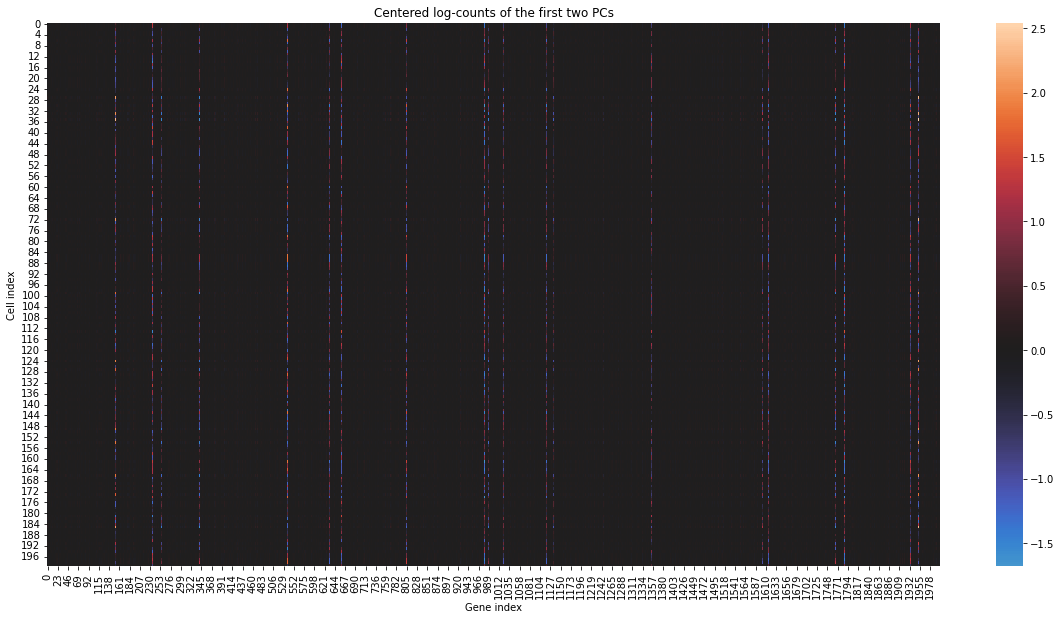

In [20]:
# Visualize the data using a heatmap
plt.figure(figsize = (20, 10))
sns.heatmap(data_PCA, center = 0)
plt.xlabel('Gene index')
plt.ylabel('Cell index')
plt.title('Centered log-counts of the first two PCs')
plt.show()

As seen from the heatmap above, there are no apparent patterns that emerge by plotting our heatmap of cells and genes according to their respective arbitrary indices. Therefore, it may be more informative to see if more distinguishable patterns will emerge if we were to sort the cells by their cluster assignments as shown below.

In [21]:
def cluster_heatmap(data_df, xlabs = '', ylabs = '', title = ''):
    """
    Plots heatmap of data with white lines delimiting cluster assignments
    """
    clusters, counts = np.unique(data_df.index, return_counts = True)
    cum_sum = np.cumsum(counts)
    fig, ax = plt.subplots(figsize = (20, 10))
    sns.heatmap(data_df, center = 0)
    x_min, x_max = plt.xlim()
    for s in cum_sum:
        ax.hlines(y = s, xmin = x_min, xmax = x_max, color = 'white')
    plt.xlabel(xlabs)
    plt.ylabel(ylabs)
    plt.title(title)

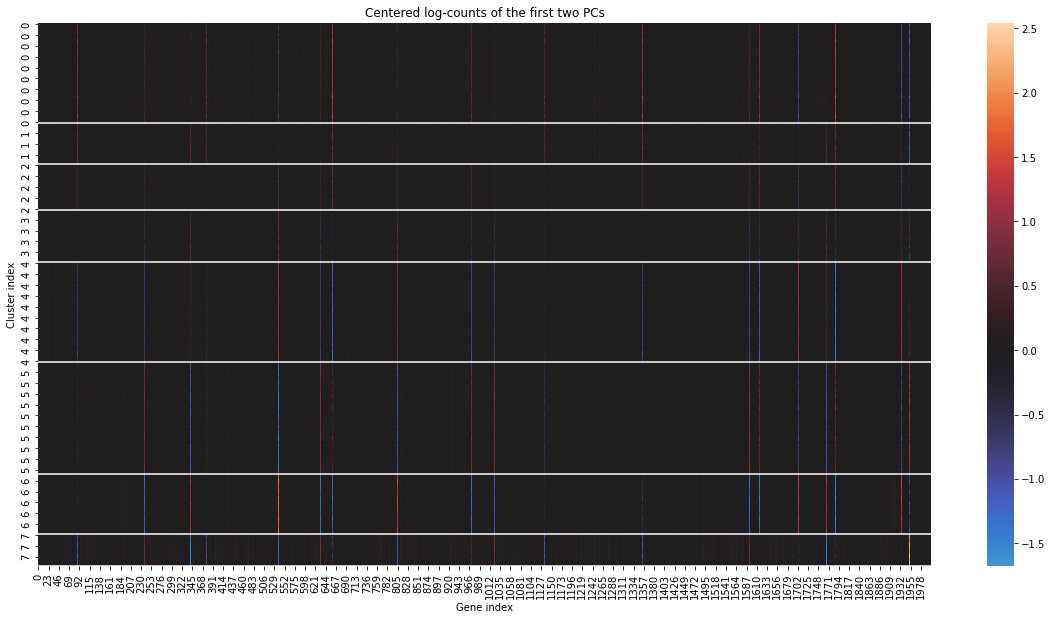

In [22]:
# Sort the data according to their cluster assignments
data_PCA_df = pd.DataFrame(data_PCA, index = assignments_PCA)
data_PCA_df_sorted = data_PCA_df.sort_index(axis = 0)

cluster_heatmap(data_PCA_df_sorted, xlabs = 'Gene index', ylabs = 'Cluster index', 
                title = 'Centered log-counts of the first two PCs')

Following sorting of the cells by their cluster assignments, we see that there are more pronounced patterns that emerge; yet, the majority of genes do not have any correlation with the cells, thus giving us a significant amount of black space.

To enhance this visualization, we will filter our genes to only keep those that have been previously identified as highly influential genes and re-plot the condensed heatmap.

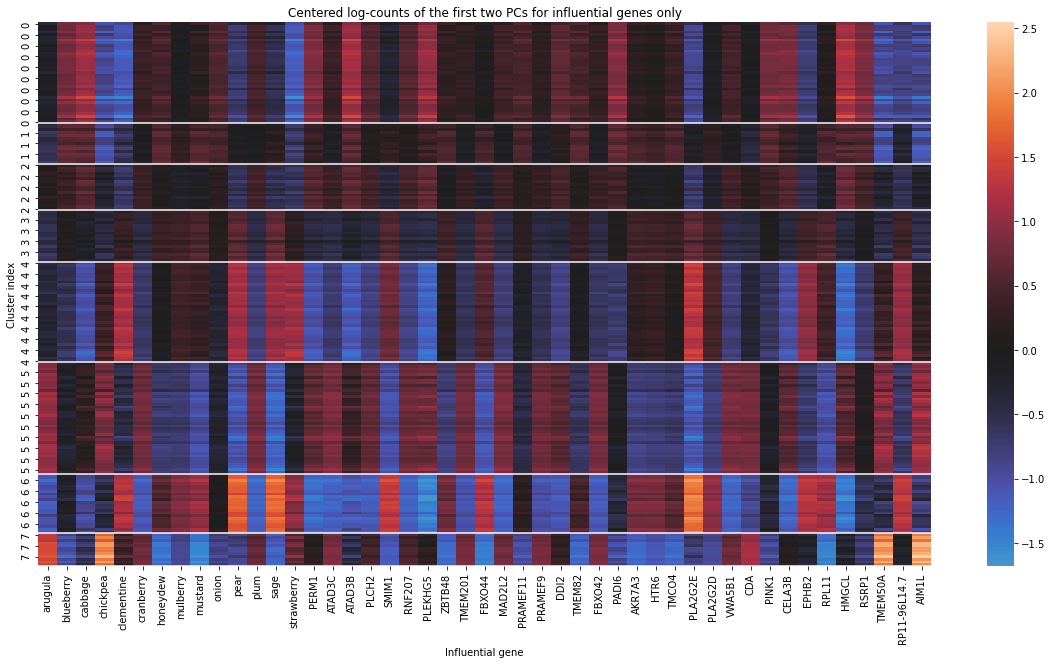

In [23]:
# Visualize only influential genes
data_PCA_df_sorted_influential = data_PCA_df_sorted.iloc[:, influential_gene_idx]
data_PCA_df_sorted_influential.columns = influential_genes
cluster_heatmap(data_PCA_df_sorted_influential, xlabs = 'Influential gene', ylabs = 'Cluster index', 
                title = 'Centered log-counts of the first two PCs for influential genes only')

After condensing the genes to keep only the influential genes based on our reconstructed data using the projected data and eigenvectors for the first two principal components, the 8 clusters are apparent as shown in the above heatmap.

Taken together, we can conclude that Watson's claim of the 8 morphologically distinct cell types is correct based on our PCA and K-means results.